<a href="https://colab.research.google.com/github/TheKreator666/Ekpa-ai-cyber-security-course/blob/main/IDS_IPS_DarkNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# ========================
# Imports
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import os


In [26]:
# ========================
# Set seeds
# ========================
np.random.seed(42)
tf.random.set_seed(42)

# ========================
# Load & Clean Dataset
# ========================
def loadDataset():
    filename = 'https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/DarkNet.csv'
    df = pd.read_csv(filename, low_memory=False)

    # Labels
    label = np.array([l.upper() for l in df.iloc[:, -1].astype(str).values])

    # Merge similar labels
    merge_map = {
        'AUDIO-STREAMING': 'AUDIO-STREAMING',
        'AUDIO-STREAMING ': 'AUDIO-STREAMING',
        'VIDEO-STREAMING': 'VIDEO-STREAMING',
        'VIDEO-STREAMING ': 'VIDEO-STREAMING',
        'FILE-TRANSFER': 'FILE-TRANSFER',
        'FILE-TRANSFER ': 'FILE-TRANSFER'
    }
    label = np.array([merge_map.get(l, l) for l in label])

    unique_labels = np.unique(label)
    label_map = {name: idx for idx, name in enumerate(unique_labels)}
    label = np.array([label_map[l] for l in label])

    # Numeric features only
    features = df.drop(columns=[df.columns[-1]])
    numeric_features = features.select_dtypes(include=[np.number])
    numeric_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_features.fillna(0, inplace=True)
    data = numeric_features.to_numpy().astype('float32')

    # Split
    train_data, test_data, train_label, test_label = train_test_split(
        data, label, test_size=0.2, stratify=label
    )
    train_data, val_data, train_label, val_label = train_test_split(
        train_data, train_label, test_size=0.125, stratify=train_label
    )

    # Scale
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    test_data = scaler.transform(test_data)

    return train_data, train_label, val_data, val_label, test_data, test_label, unique_labels

# Load dataset
train_data, train_labelp, val_data, val_labelp, test_data, test_labelp, unique_labels = loadDataset()
nclass = len(unique_labels)




In [27]:
# One-hot encode
train_label = to_categorical(train_labelp, nclass)
val_label   = to_categorical(val_labelp, nclass)
test_label  = to_categorical(test_labelp, nclass)

# ========================
# Focal loss (optional)
# ========================
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed

# ========================
# Model Definitions
# ========================
def build_dense_model(inshape, nclass, N=128, lr=0.001):
    model = Sequential([
        Input(shape=(inshape,)),
        Dense(N, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(N, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(nclass, activation='softmax')
    ])
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_conv1d_model(inshape, nclass, N=64, lr=0.001):
    model = Sequential([
        Input(shape=(inshape,1)),
        Conv1D(32, kernel_size=3, activation='relu'),
        Conv1D(64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(N, activation='relu'),
        Dropout(0.3),
        Dense(nclass, activation='softmax')
    ])
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(inshape, nclass, N=64, lr=0.001):
    model = Sequential([
        Input(shape=(inshape,1)),
        LSTM(N, return_sequences=False),
        Dropout(0.3),
        Dense(N, activation='relu'),
        Dense(nclass, activation='softmax')
    ])
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
# ========================
# Prepare data for Conv1D / LSTM
# ========================
train_data_seq = np.expand_dims(train_data, axis=2)
val_data_seq   = np.expand_dims(val_data, axis=2)
test_data_seq  = np.expand_dims(test_data, axis=2)

# ========================
# Class Weights
# ========================
raw_weights = compute_class_weight('balanced', classes=np.unique(train_labelp), y=train_labelp)
class_weights = {i: min(w,10) for i,w in enumerate(raw_weights)}
print("Class Weights (capped):", class_weights)

Class Weights (capped): {0: np.float64(1.1371517907902218), 1: np.float64(1.6508253094910592), 2: np.float64(0.7469193427931292), 3: np.float64(1.3948744769874477), 4: np.float64(0.7666730548102721), 5: np.float64(0.6252083767451553), 6: np.float64(0.8776875822729268), 7: np.float64(2.4041466346153846)}


In [29]:
# ========================
# Compute class weights
# ========================
raw_weights = compute_class_weight('balanced', classes=np.unique(train_labelp), y=train_labelp)
class_weights = {i: min(w, 10) for i, w in enumerate(raw_weights)}

# ========================
# Reshape for Conv1D/LSTM
# ========================
train_data_seq = train_data[..., np.newaxis]
val_data_seq   = val_data[..., np.newaxis]
test_data_seq  = test_data[..., np.newaxis]

# ========================
# Train models
# ========================
epochs = 50
batch_size = 128
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Dense
dense_model = build_dense_model(train_data.shape[1], nclass)
dense_model.fit(train_data, train_label, validation_data=(val_data, val_label),
                epochs=epochs, batch_size=batch_size, class_weight=class_weights,
                callbacks=[earlyStopping], verbose=1)
dense_model.save('dense_model.h5')

# Conv1D
conv_model = build_conv1d_model(train_data.shape[1], nclass)
conv_model.fit(train_data_seq, train_label, validation_data=(val_data_seq, val_label),
               epochs=epochs, batch_size=batch_size, class_weight=class_weights,
               callbacks=[earlyStopping], verbose=1)
conv_model.save('conv1d_model.h5')

# LSTM
lstm_model = build_lstm_model(train_data.shape[1], nclass)
lstm_model.fit(train_data_seq, train_label, validation_data=(val_data_seq, val_label),
               epochs=epochs, batch_size=batch_size, class_weight=class_weights,
               callbacks=[earlyStopping], verbose=1)
lstm_model.save('lstm_model.h5')

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3579 - loss: 1.8366 - val_accuracy: 0.5131 - val_loss: 1.2150
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4893 - loss: 1.3293 - val_accuracy: 0.5360 - val_loss: 1.1244
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5238 - loss: 1.2290 - val_accuracy: 0.5512 - val_loss: 1.0598
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5494 - loss: 1.1604 - val_accuracy: 0.5710 - val_loss: 1.0204
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5622 - loss: 1.1161 - val_accuracy: 0.5738 - val_loss: 0.9875
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5691 - loss: 1.0834 - val_accuracy: 0.5798 - val_loss: 0.9686
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5787 - loss: 1.0562 - val_accuracy: 0.5881 - val_loss: 0.9470
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5792 - loss: 1.0409 - val_accuracy: 

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4095 - loss: 1.5676 - val_accuracy: 0.5421 - val_loss: 1.0754
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5499 - loss: 1.1672 - val_accuracy: 0.5780 - val_loss: 0.9816
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5770 - loss: 1.0674 - val_accuracy: 0.5884 - val_loss: 0.9309
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5884 - loss: 1.0233 - val_accuracy: 0.6048 - val_loss: 0.8872
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5975 - loss: 0.9853 - val_accuracy: 0.6025 - val_loss: 0.8747
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6015 - loss: 0.9659 - val_accuracy: 0.6172 - val_loss: 0.8480
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6060 - loss: 0.9428 - val_accuracy: 0.6199 - val_loss: 0.8295
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6134 - loss: 0.9287 - va

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.2316 - loss: 1.9380 - val_accuracy: 0.3526 - val_loss: 1.5990
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.3696 - loss: 1.5857 - val_accuracy: 0.3971 - val_loss: 1.4357
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - accuracy: 0.4179 - loss: 1.4494 - val_accuracy: 0.4339 - val_loss: 1.3666
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.4489 - loss: 1.3863 - val_accuracy: 0.4793 - val_loss: 1.2837
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.4674 - loss: 1.3272 - val_accuracy: 0.4907 - val_loss: 1.2481
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.4827 - loss: 1.2925 - val_accuracy: 0.4964 - val_loss: 1.2128
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.4878 - loss: 1.2757 - val_accuracy: 0.4968 - val_loss: 1.1970
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.4995 - loss: 1.25

In [30]:
# ========================
# IPS Ensemble Inference
# ========================
def ips_response_ensemble(dense_model, conv_model, lstm_model, data, data_seq, labels, threshold=0.5):
    blocked = []
    allowed = []
    pred_names = []
    actions = []

    pred_dense = dense_model.predict(data)
    pred_conv  = conv_model.predict(data_seq)
    pred_lstm  = lstm_model.predict(data_seq)

    pred_avg = (pred_dense + pred_conv + pred_lstm) / 3
    pred_y = pred_avg.argmax(axis=-1)
    pred_conf = pred_avg.max(axis=-1)

    for i in range(len(pred_y)):
        pred_name = unique_labels[pred_y[i]]
        pred_names.append(pred_name)
        if pred_conf[i] >= threshold and pred_name != unique_labels[labels[i]]:
            actions.append('BLOCK')
            blocked.append(i)
        else:
            actions.append('ALLOW')
            allowed.append(i)

    print(f'Total blocked: {len(blocked)} out of {len(labels)} samples')
    print(f'Total allowed: {len(allowed)} out of {len(labels)} samples')
    for i in range(min(10, len(pred_y))):
        print(f"Sample {i}: Predicted={pred_names[i]}, Confidence={pred_conf[i]:.2f}, Action={actions[i]}")

    return blocked, allowed, pred_names, actions

# Run IPS
blocked, allowed, pred_names, actions = ips_response_ensemble(
    dense_model, conv_model, lstm_model,
    test_data, test_data_seq, test_labelp,
    threshold=0.5
)

429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Total blocked: 1365 out of 13716 samples
Total allowed: 12351 out of 13716 samples
Sample 0: Predicted=VOIP, Confidence=0.42, Action=ALLOW
Sample 1: Predicted=FILE-TRANSFER, Confidence=0.97, Action=ALLOW
Sample 2: Predicted=BROWSING, Confidence=0.43, Action=ALLOW
Sample 3: Predicted=BROWSING, Confidence=0.63, Action=BLOCK
Sample 4: Predicted=VIDEO-STREAMING, Confidence=0.47, Action=ALLOW
Sample 5: Predicted=VOIP, Confidence=0.42, Action=ALLOW
Sample 6: Predicted=FILE-TRANSFER, Confidence=0.99, Action=ALLOW
Sample 7: Predicted=BROWSING, Confidence=0.55, Action=BLOCK
Sample 8: Predicted=P2P, Confidence=1.00, Action=ALLOW
Sample 9: Predicted=AUDIO-STREAMING, Confidence=0.56, Action=ALLOW


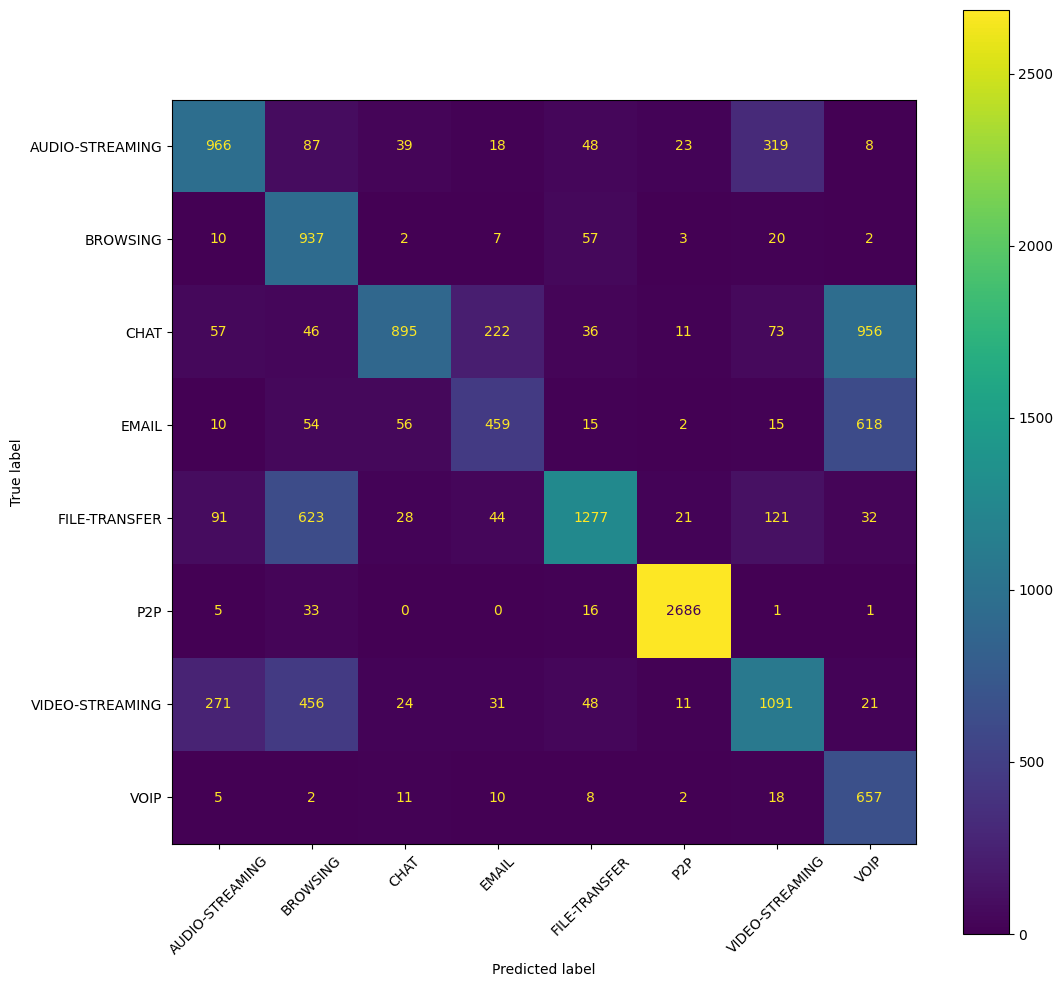

                 precision    recall  f1-score   support

AUDIO-STREAMING       0.68      0.64      0.66      1508
       BROWSING       0.42      0.90      0.57      1038
           CHAT       0.85      0.39      0.53      2296
          EMAIL       0.58      0.37      0.45      1229
  FILE-TRANSFER       0.85      0.57      0.68      2237
            P2P       0.97      0.98      0.98      2742
VIDEO-STREAMING       0.66      0.56      0.60      1953
           VOIP       0.29      0.92      0.44       713

       accuracy                           0.65     13716
      macro avg       0.66      0.67      0.62     13716
   weighted avg       0.74      0.65      0.66     13716



In [31]:
# ========================
# Confusion Matrix & Report
# ========================
cm = confusion_matrix(test_labelp, np.array([unique_labels.tolist().index(n) for n in pred_names]))
disp = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, xticks_rotation=45)
plt.show()

print(classification_report(test_labelp,
                            np.array([unique_labels.tolist().index(n) for n in pred_names]),
                            target_names=unique_labels))